In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,mean_squared_error

/Users/shri/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/shri/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### 1. Classification Feature Selection

In [17]:
# Load Paribas dataset from Kaggle 
data=pd.read_csv('datasets/paribas.csv',nrows=50000)
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [18]:
# In practise, feature selection should be done after data preprocessing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target.

# Here for simplicity we'll use only numerical variables.
numerics=['int16','int32','int64','float16','float32','float64']
numeric_vals=data.select_dtypes(include=numerics).columns
data=data[numeric_vals]
data.shape

(50000, 114)

In [19]:
# Split the dataset into training and testing to avoid overfitting
x_train,x_test,y_train,y_test=train_test_split(data.drop(labels=['target','ID'],axis=1),
                                              data['target'],test_size=0.3,random_state=0)
x_train.shape,x_test.shape

((35000, 112), (15000, 112))

In [20]:
# Now let's build a loop to generate ROC-AUC values 
# for all the features of the train set
roc_values=[]
for feature in x_train.columns:
    clf=DecisionTreeClassifier().fit(x_train[feature].fillna(0).to_frame(),y_train)
    y_scored=clf.predict_proba(x_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test,y_scored[:,1]))

In [21]:
# Analysing different roc_Values
roc_values=pd.Series(roc_values)
roc_values.index=x_train.columns

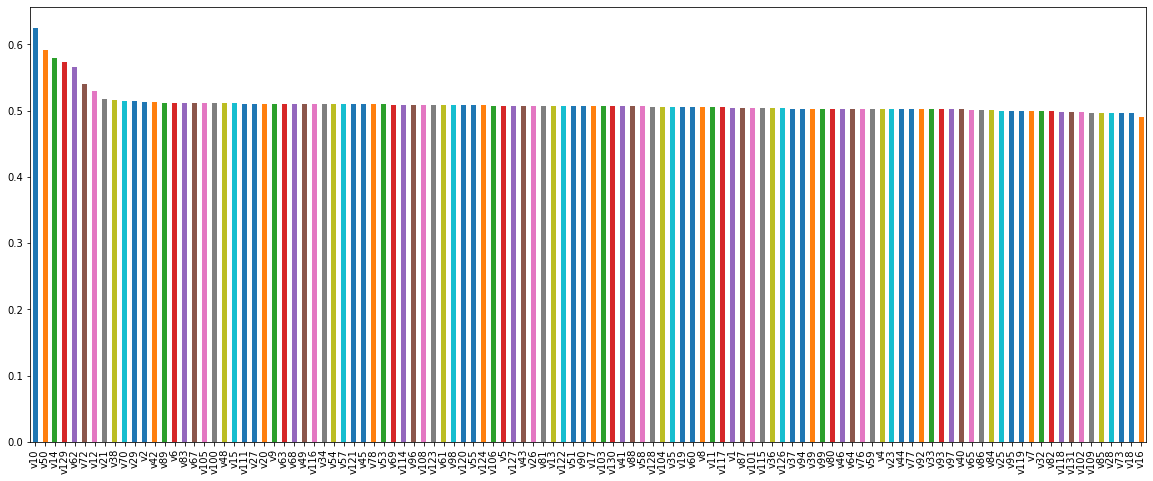

In [22]:
roc_values.sort_values(ascending=False).plot.bar(figsize=(20,8))

In [23]:
# a roc auc value of 0.5 indicated random decision
# hence check how many features show roc-auc value more then that
len(roc_values[roc_values>0.5])

98

98 of 112 features show predictive preformance above 0.5. This means we can remove 14 features from the dataset using this method.

We can tune the DT model to improve perdictions. But remember that the key here is not to make ultra predictive Decision Trees, rather to use to screen quickly for important features.

### 2. Regression Feature Selection

In [24]:
# FOR REGRESSION WE'LL USE HOUSEPRICE PREDICTION FROM KAGGLE
data=pd.read_csv('datasets/houseprice.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [25]:
# Selecting numeric cols
numeric_vals=data.select_dtypes(include=numerics).columns
data=data[numeric_vals]
data.shape

(1460, 38)

In [26]:
# Seperate training and testing dataset
x_train,x_test,y_train,y_test=train_test_split(data.drop(labels=['SalePrice','Id'],axis=1),
                                              data['SalePrice'],test_size=0.3,random_state=0)
x_train.shape,x_test.shape

((1022, 36), (438, 36))

In [27]:
# Creating loop for different mse values
mse_values=[]
for feature in x_train.columns:
    clf=DecisionTreeRegressor().fit(x_train[feature].fillna(0).to_frame(),y_train)
    y_scored=clf.predict(x_test[feature].fillna(0).to_frame())
    mse_values.append(mean_squared_error(y_test,y_scored))

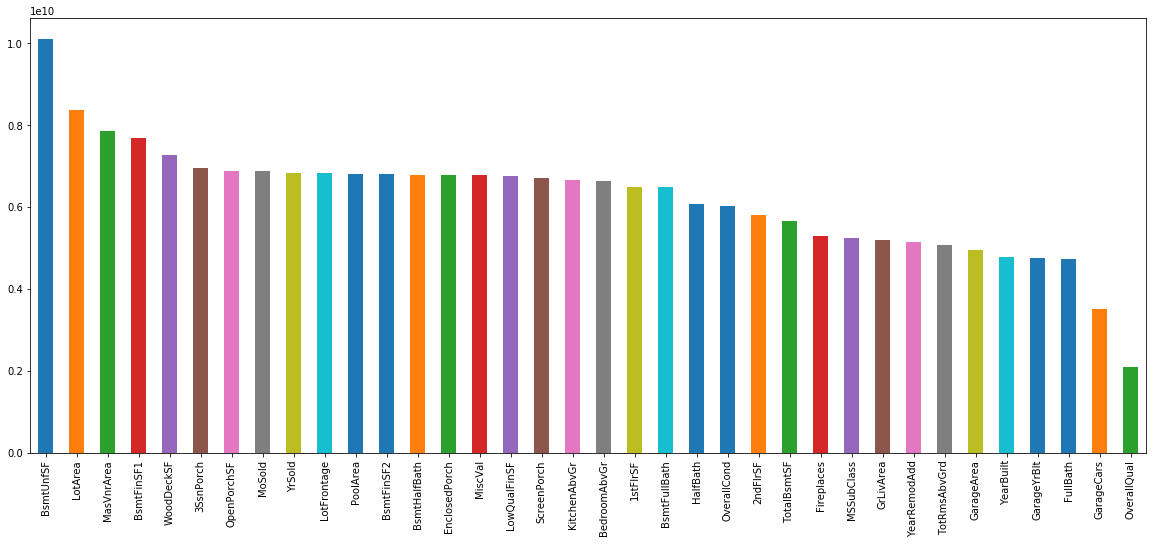

In [29]:
# Analysing MSE Values
mse_values=pd.Series(mse_values)
mse_values.index=x_train.columns
mse_values.sort_values(ascending=False).plot.bar(figsize=(20,8))

Remember MSE stand for Mean Squared Error and lesser the error more better that feature is for prediction. Hence, we look for features with small mse values. 
 
For the mse, where to put the cutoff is arbitrary as well. It depends on how many features you would like to end up with